## Learning the Quantile function of a Guassian


In [4]:
import pennylane as qml
from pennylane import numpy as np
from scipy.special import erf

# Circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define target quantile function (Gaussian)
def gaussian_quantile(z, mu=0.0, sigma=1.0):
    """Gaussian quantile function."""
    return mu + sigma * np.sqrt(2) * erf(np.sqrt(2) * (z - 0.5))

# Quantum circuit components
def feature_map(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def variational_ansatz(params):
    """Hardware-efficient ansatz."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def quantum_circuit(z, params):
    """Quantum circuit."""
    feature_map(z)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 10

# Training setup
np.random.seed(42)
z_vals = np.linspace(0, 1, 50)  # Uniform latent variables
targets = np.array([gaussian_quantile(z) for z in z_vals])  # Target quantile values
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))  # Random initial parameters

# Training loop
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    if epoch % 10 == 0:
        l = loss(params, z_vals, targets)
        print(f"Epoch {epoch}: Loss = {l:.6f}")

# Test the circuit
test_z = 0.7
predicted = quantum_circuit(test_z, params)
actual = gaussian_quantile(test_z)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")


Epoch 0: Loss = 0.035425
Test z = 0.7, Predicted Q(z) = 0.48223846801628373, Actual Q(z) = 0.4395990697459344


In [28]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define target Gaussian quantile function
def gaussian_quantile(z, mu=0.0, sigma=1.0):
    """Gaussian quantile function."""
    return mu + sigma * np.sqrt(2) * erf(np.sqrt(2) * (z - 0.5))

# Quantum circuit components
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t):
    """Feature map to encode time t."""
    for i in range(n_qubits):
        qml.RY(np.arcsin(t), wires=i)


def variational_ansatz(params):
    """Hardware-efficient ansatz."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def quantum_circuit(z, params):
    """Quantum circuit."""
    feature_map(z)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 10

# Generate training data
z_vals = np.linspace(0, 1, 50)  # Latent variables
targets = np.array([gaussian_quantile(z) for z in z_vals])  # Target quantile values

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
losses = []
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    current_loss = loss(params, z_vals, targets)
    losses.append(current_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# Test the circuit on a new value
test_z = 0.7
predicted = quantum_circuit(test_z, params)
actual = gaussian_quantile(test_z)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")

# Predictions after training
predictions = np.array([quantum_circuit(z, params) for z in z_vals])

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Over Training", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


# Plot the learned quantile function
plt.figure(figsize=(10, 6))
plt.plot(z_vals, targets, label="True Quantile (Gaussian)", color="blue", linewidth=2)
plt.scatter(z_vals, predictions, label="Learned Quantile (Circuit Output)", color="red", alpha=0.7)
plt.title("Learning Gaussian Quantile with Quantum Circuit", fontsize=14)
plt.xlabel("Latent Variable (z)", fontsize=12)
plt.ylabel("Quantile Function Q(z)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Display data for first few points
data = np.column_stack((z_vals, targets, predictions))
print("First few data points (z, True Q(z), Learned Q(z)):")
print(data[:5])

KeyboardInterrupt: 

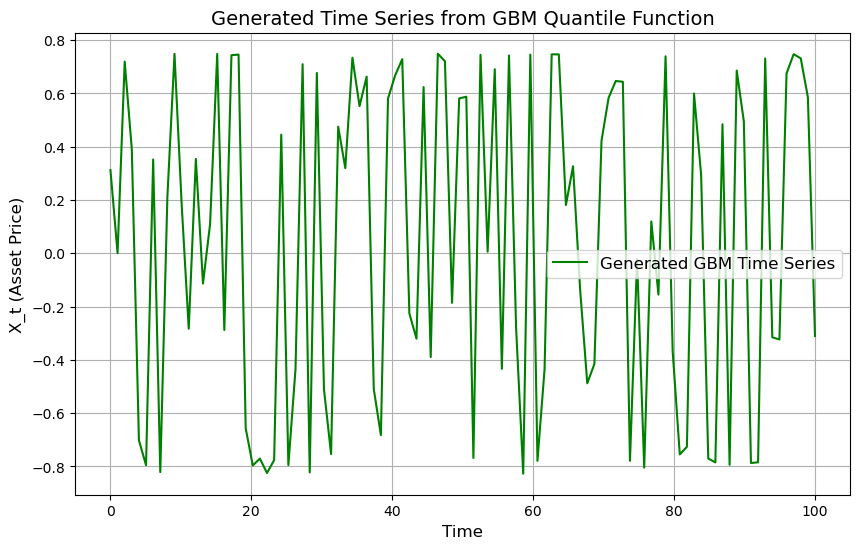

In [ ]:
# Function to generate a time-series from the quantile function
def generate_gbm_time_series(t_steps):
    time_series = []
    for t in t_steps:
        # Sample from uniform distribution for each time step
        z_t = np.random.uniform(0, 1)
        # Use the learned quantum circuit to get Q(z_t, t)
        X_t = quantum_circuit(z_t, params)
        time_series.append(X_t)
    return np.array(time_series)

# Generate a time-series
t_steps = np.linspace(0, 100, 100)  # Time steps from 0 to 1
gbm_time_series = generate_gbm_time_series(t_steps)

# Plot the generated time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, gbm_time_series, label="Generated GBM Time Series", color="green")
plt.title("Generated Time Series from GBM Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t (Asset Price)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Epoch 0: Loss = 2.524780
Epoch 10: Loss = 1.011159
Epoch 20: Loss = 0.730028
Epoch 30: Loss = 0.690799
Epoch 40: Loss = 0.617554
Epoch 50: Loss = 0.619078
Epoch 60: Loss = 0.612154
Epoch 70: Loss = 0.610323
Epoch 80: Loss = 0.610021
Epoch 90: Loss = 0.609581
Test z = 0.7, Predicted Q(z) = 0.9688204394791363, Actual Q(z) = 1.794775783684227


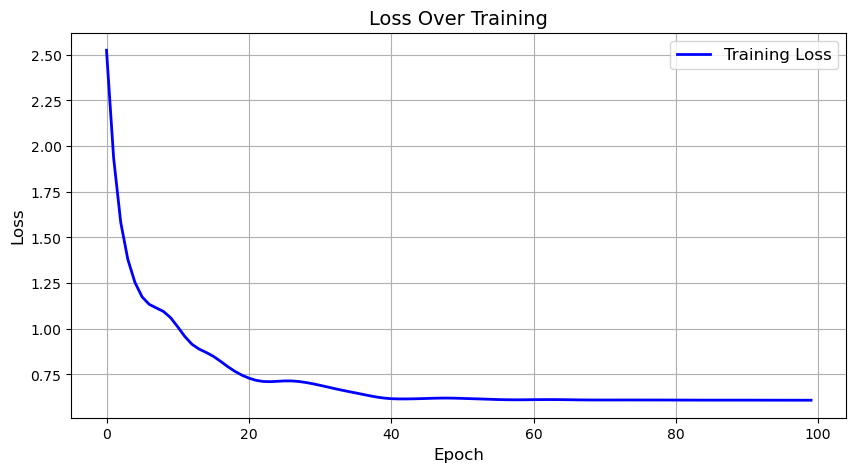

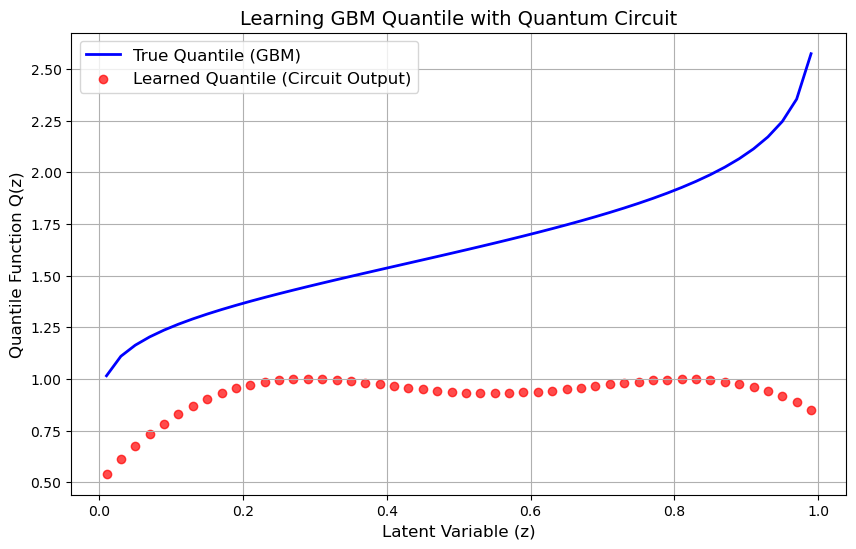

First few data points (z, True Q(z), Learned Q(z)):
[[0.01       1.01483945 0.54090484]
 [0.03       1.10942435 0.60987698]
 [0.05       1.1630307  0.67348347]
 [0.07       1.2030281  0.73141977]
 [0.09       1.23596123 0.78347855]]


In [9]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# GBM parameters
mu = 0.5      # Drift coefficient
sigma = 0.2   # Volatility
X0 = 1.0      # Initial value of the process

# Define GBM quantile function
def gbm_quantile(z, t, mu=mu, sigma=sigma, X0=X0):
    """Quantile function for GBM at time t."""
    return X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * norm.ppf(z))

# Quantum circuit components
def feature_map(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def variational_ansatz(params):
    """Hardware-efficient ansatz."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def quantum_circuit(z, params):
    """Quantum circuit."""
    feature_map(z)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 100

# Generate training data
t = 1.0  # Time point
z_vals = np.linspace(0.01, 0.99, 50)  
targets = np.array([gbm_quantile(z, t) for z in z_vals])  


np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
losses = []
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    current_loss = loss(params, z_vals, targets)
    losses.append(current_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# Test the circuit on a new value
test_z = 0.7
predicted = quantum_circuit(test_z, params)
actual = gbm_quantile(test_z, t)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")

# Predictions after training
predictions = np.array([quantum_circuit(z, params) for z in z_vals])

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Over Training", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plot the learned quantile function
plt.figure(figsize=(10, 6))
plt.plot(z_vals, targets, label="True Quantile (GBM)", color="blue", linewidth=2)
plt.scatter(z_vals, predictions, label="Learned Quantile (Circuit Output)", color="red", alpha=0.7)
plt.title("Learning GBM Quantile with Quantum Circuit", fontsize=14)
plt.xlabel("Latent Variable (z)", fontsize=12)
plt.ylabel("Quantile Function Q(z)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Display data for first few points
data = np.column_stack((z_vals, targets, predictions))
print("First few data points (z, True Q(z), Learned Q(z)):")
print(data[:5])


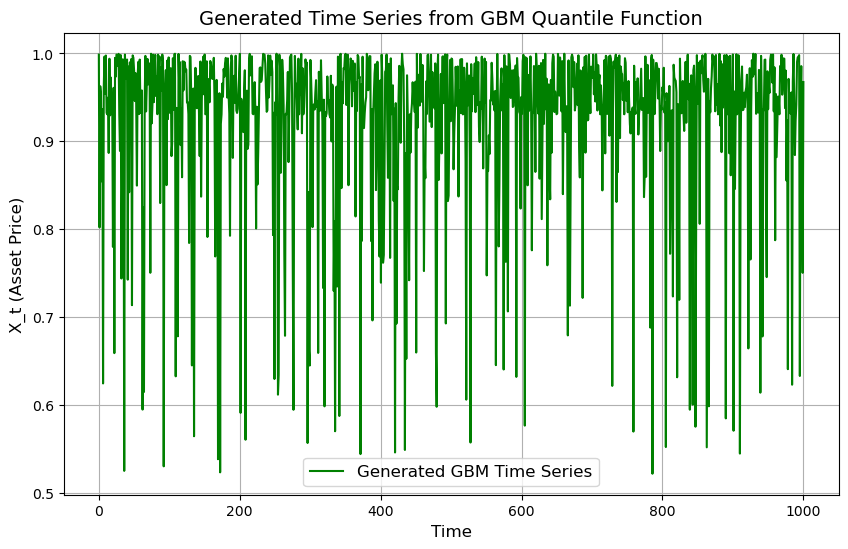

In [10]:
# Function to generate a time-series from the quantile function
def generate_gbm_time_series(t_steps, mu=mu, sigma=sigma, X0=X0):
    time_series = []
    for t in t_steps:
        # Sample from uniform distribution for each time step
        z_t = np.random.uniform(0, 1)
        # Use the learned quantum circuit to get Q(z_t, t)
        X_t = quantum_circuit(z_t, params)
        time_series.append(X_t)
    return np.array(time_series)

# Generate a time-series
t_steps = np.linspace(0, 1000, 1000)  # Time steps from 0 to 1
gbm_time_series = generate_gbm_time_series(t_steps)

# Plot the generated time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, gbm_time_series, label="Generated GBM Time Series", color="green")
plt.title("Generated Time Series from GBM Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t (Asset Price)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [11]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Quantum circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# GBM parameters
mu = 0.1       # Drift coefficient
sigma = 0.2    # Volatility
X0 = 1.0       # Initial value of the process

# Define the GBM quantile function
def gbm_quantile(z, t, mu=mu, sigma=sigma, X0=X0):
    """Quantile function for GBM at time t."""
    return X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * norm.ppf(z))

# Quantum circuit feature maps
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t):
    """Feature map to encode time t."""
    for i in range(n_qubits):
        qml.RY(np.arcsin(t), wires=i)

# Variational ansatz
def variational_ansatz(params):
    """Hardware-efficient ansatz with entangling CNOT gates."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(z, t, params):
    """Quantum circuit representing the quantile function."""
    feature_map_latent_variable(z)  # Encode z
    feature_map_time(t)             # Encode t
    variational_ansatz(params)      # Apply variational ansatz
    return qml.expval(qml.PauliZ(0))  # Measurement

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, t, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 5

# Generate training data
t = 1.0  # Time point
z_vals = np.linspace(0.01, 0.99, 50)  # Latent variables (avoid extreme values for stability)
targets = np.array([gbm_quantile(z, t) for z in z_vals])  # Target quantile values

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
losses = []
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    current_loss = loss(params, z_vals, targets)
    losses.append(current_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# Test the circuit on a new value
test_z = 0.7
predicted = quantum_circuit(test_z, t, params)
actual = gbm_quantile(test_z, t)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")

# Predictions after training
predictions = np.array([quantum_circuit(z, t, params) for z in z_vals])

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Over Training", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plot the learned quantile function
plt.figure(figsize=(10, 6))
plt.plot(z_vals, targets, label="True Quantile (GBM)", color="blue", linewidth=2)
plt.scatter(z_vals, predictions, label="Learned Quantile (Circuit Output)", color="red", alpha=0.7)
plt.title("Learning GBM Quantile with Quantum Circuit", fontsize=14)
plt.xlabel("Latent Variable (z)", fontsize=12)
plt.ylabel("Quantile Function Q(z)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Display data for first few points
data = np.column_stack((z_vals, targets, predictions))
print("First few data points (z, True Q(z), Learned Q(z)):")
print(data[:5])

# Generate a time-series using the learned quantile function
def generate_gbm_time_series(t_steps, params, X0=X0):
    """Generate a GBM time-series using the learned quantile function."""
    time_series = []
    for t in t_steps:
        z_t = np.random.uniform(0, 1)  # Sample from U[0, 1]
        X_t = quantum_circuit(z_t, t, params)  # Use the trained circuit
        time_series.append(X_t)
    return np.array(time_series)

# Generate a time-series
t_steps = np.linspace(0, 1, 100)  # Time steps from 0 to 1
gbm_time_series = generate_gbm_time_series(t_steps, params)

# Plot the generated time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, gbm_time_series, label="Generated GBM Time Series", color="green")
plt.title("Generated Time Series from GBM Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t (Asset Price)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Epoch 0: Loss = 1.077105
Test z = 0.7, Predicted Q(z) = 0.717581560611374, Actual Q(z) = 1.2030741859428618


KeyboardInterrupt: 

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Quantum circuit parameters
n_qubits = 8
depth = 7
dev = qml.device("default.qubit", wires=n_qubits)

# Define linear time-series quantile function
alpha = 2.0  # Scaling factor for time
beta = 1.0   # Scaling factor for latent variable

def linear_quantile(z, t, alpha=alpha, beta=beta):
    """Quantile function for a linear time-series."""
    return alpha * t + beta * z

# Quantum circuit feature maps
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t):
    """Feature map to encode time t."""
    for i in range(n_qubits):
        qml.RY(np.arcsin(t), wires=i)

# Variational ansatz
def variational_ansatz(params):
    """Hardware-efficient ansatz with entangling CNOT gates."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(z, t, params):
    """Quantum circuit representing the quantile function."""
    feature_map_latent_variable(z)  # Encode z
    feature_map_time(t)             # Encode t
    variational_ansatz(params)      # Apply variational ansatz
    return qml.expval(qml.PauliZ(0))  # Measurement

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, t, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)





Epoch 0: Loss = 6.715855
Epoch 1: Loss = 6.562720
Epoch 2: Loss = 6.409484
Epoch 3: Loss = 6.256419
Epoch 4: Loss = 6.103986
Epoch 5: Loss = 5.952281
Epoch 6: Loss = 5.801351
Epoch 7: Loss = 5.651720
Epoch 8: Loss = 5.504308
Epoch 9: Loss = 5.360261
Epoch 10: Loss = 5.220870
Epoch 11: Loss = 5.087464
Epoch 12: Loss = 4.961255
Epoch 13: Loss = 4.843185
Epoch 14: Loss = 4.733793
Epoch 15: Loss = 4.633102
Epoch 16: Loss = 4.540594
Epoch 17: Loss = 4.455310
Epoch 18: Loss = 4.376054
Epoch 19: Loss = 4.301631
Epoch 20: Loss = 4.231032
Epoch 21: Loss = 4.163513
Epoch 22: Loss = 4.098590
Epoch 23: Loss = 4.035977
Epoch 24: Loss = 3.975526
Epoch 25: Loss = 3.917150
Epoch 26: Loss = 3.860772
Epoch 27: Loss = 3.806296
Epoch 28: Loss = 3.753592
Epoch 29: Loss = 3.702512
Epoch 30: Loss = 3.652908
Epoch 31: Loss = 3.604652
Epoch 32: Loss = 3.557654
Epoch 33: Loss = 3.511868
Epoch 34: Loss = 3.467303
Epoch 35: Loss = 3.424017
Epoch 36: Loss = 3.382111
Epoch 37: Loss = 3.341715
Epoch 38: Loss = 3.302

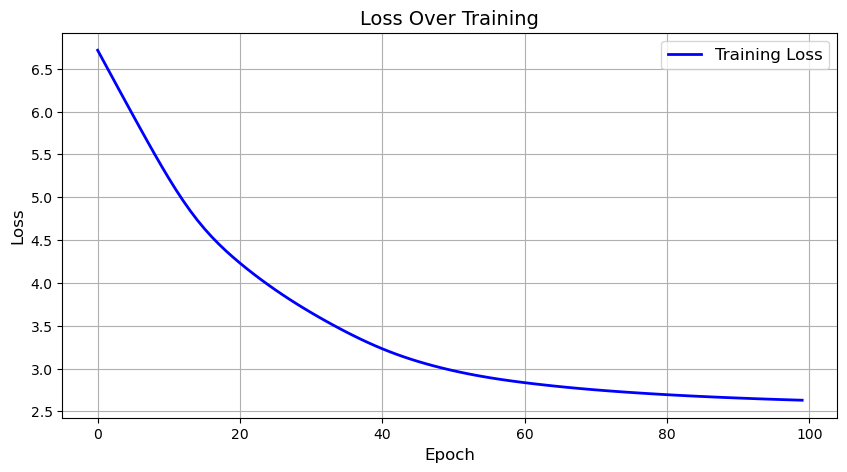

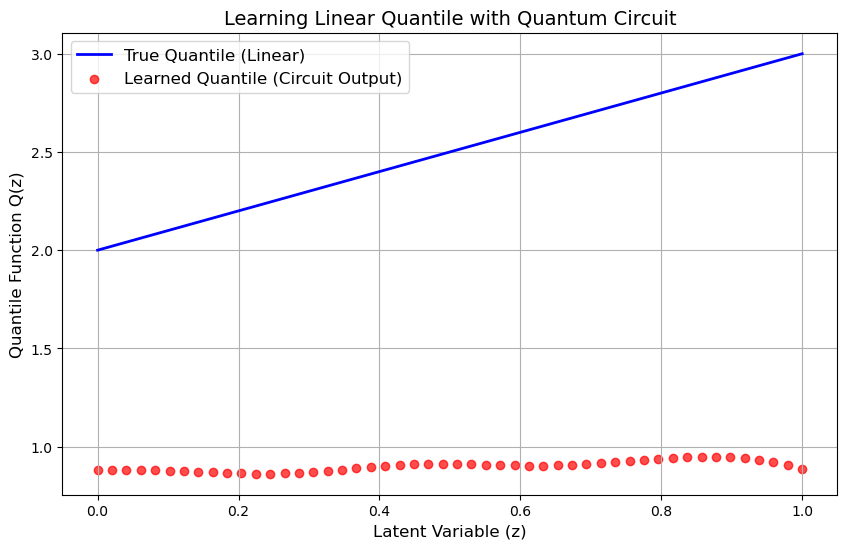

First few data points (z, True Q(z), Learned Q(z)):
[[0.         2.         0.8786795 ]
 [0.02040816 2.02040816 0.88023177]
 [0.04081633 2.04081633 0.88096834]
 [0.06122449 2.06122449 0.88077563]
 [0.08163265 2.08163265 0.8796239 ]]


In [21]:
# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.01)
epochs = 100

# Generate training data
t = 1.0  # Fixed time point for simplicity
z_vals = np.linspace(0.0, 1.0, 50)  # Latent variables
targets = np.array([linear_quantile(z, t) for z in z_vals])  # Target quantile values

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
losses = []
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    current_loss = loss(params, z_vals, targets)
    losses.append(current_loss)
    #if epoch % 10 == 0:
    print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# Test the circuit on a new value
test_z = 0.7
predicted = quantum_circuit(test_z, t, params)
actual = linear_quantile(test_z, t)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")

# Predictions after training
predictions = np.array([quantum_circuit(z, t, params) for z in z_vals])

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Over Training", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plot the learned quantile function
plt.figure(figsize=(10, 6))
plt.plot(z_vals, targets, label="True Quantile (Linear)", color="blue", linewidth=2)
plt.scatter(z_vals, predictions, label="Learned Quantile (Circuit Output)", color="red", alpha=0.7)
plt.title("Learning Linear Quantile with Quantum Circuit", fontsize=14)
plt.xlabel("Latent Variable (z)", fontsize=12)
plt.ylabel("Quantile Function Q(z)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Display data for first few points
data = np.column_stack((z_vals, targets, predictions))
print("First few data points (z, True Q(z), Learned Q(z)):")
print(data[:5])

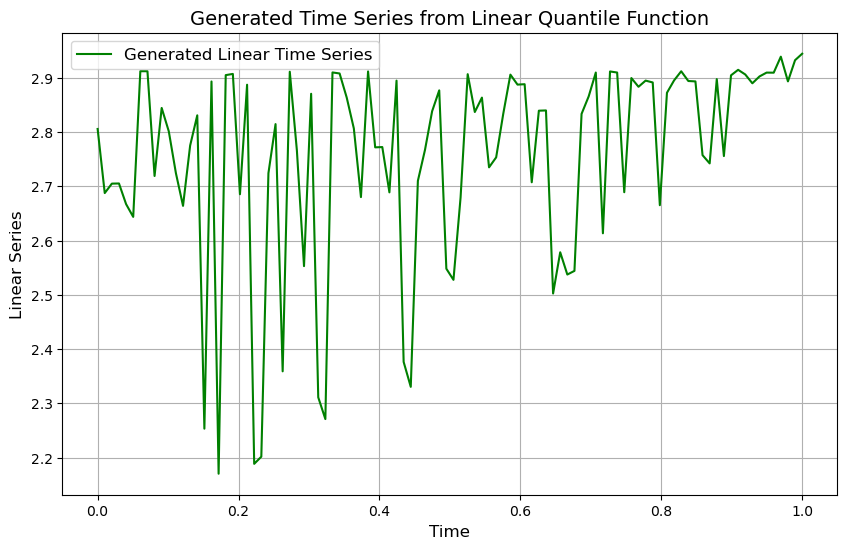

In [ ]:
# Use the learned quantum circuit to generate a time-series
def generate_linear_time_series(t_steps, params):
    """Generate a linear time-series using the learned quantile function."""
    time_series = []
    for t in t_steps:
        z_t = np.random.uniform(0, 1)  # Sample from U[0, 1]
        X_t = quantum_circuit(z_t, t, params) # Use the trained circuit
        time_series.append(X_t)
    return np.array(time_series)

# Generate a time-series
t_steps = np.linspace(0, 1, 100)  # Time steps from 0 to 1
linear_time_series = generate_linear_time_series(t_steps, params)

#Plot the generated time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, linear_time_series, label="Generated Linear Time Series", color="green")
plt.title("Generated Time Series from Linear Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Linear Series", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Epoch 0: Loss = 0.078293
Epoch 10: Loss = 0.020300
Epoch 20: Loss = 0.007865
Epoch 30: Loss = 0.004063
Epoch 40: Loss = 0.002161
Epoch 50: Loss = 0.001468
Epoch 60: Loss = 0.001194
Epoch 70: Loss = 0.000897
Epoch 80: Loss = 0.000717
Epoch 90: Loss = 0.000595
Test z = 0.7, Predicted Q(z) = 0.07456206320423853, Actual Q(z) = 0.08338598456519478


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home

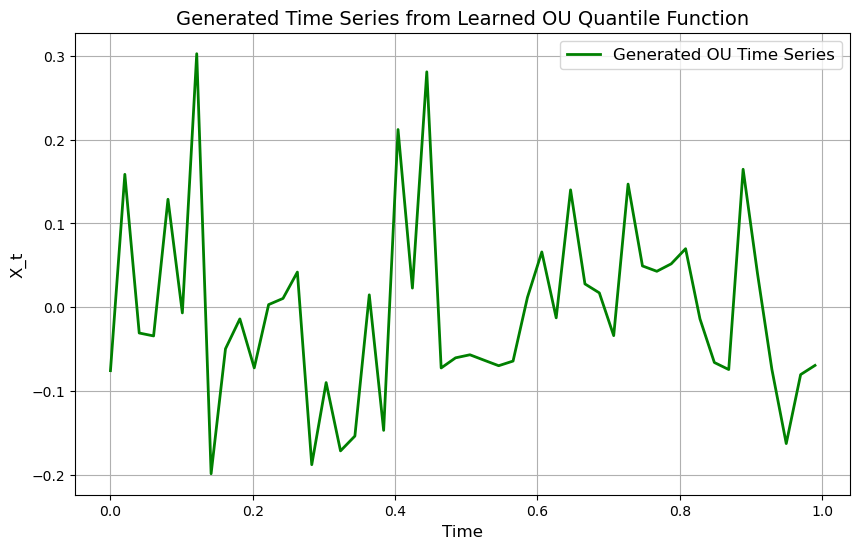

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Quantum circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# OU process parameters
nu = 0.5       # Rate of reversion
mu = 0.0       # Long-term mean
sigma = 0.2    # Volatility

# Define the quantile function for the OU process
def ou_quantile(z, t, nu=nu, mu=mu, sigma=sigma):
    """Quantile function for the OU process."""
    variance = (sigma**2 / (2 * nu)) * (1 - np.exp(-2 * nu * t))
    mean = mu + (np.exp(-nu * t) * (mu - mu))
    return mean + np.sqrt(variance) * norm.ppf(z)

# Quantum circuit feature maps
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t):
    """Feature map to encode time t."""
    for i in range(n_qubits):
        qml.RY(np.arcsin(t), wires=i)

# Variational ansatz
def variational_ansatz(params):
    """Hardware-efficient ansatz with entangling CNOT gates."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(z, t, params):
    """Quantum circuit representing the quantile function."""
    feature_map_latent_variable(z)
    feature_map_time(t)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, t, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 100

# Generate training data
t = 1.0  # Fixed time point
z_vals = np.linspace(0.01, 0.99, 50)  # Latent variables
targets = np.array([ou_quantile(z, t) for z in z_vals])  # Target quantile values

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
losses = []
for epoch in range(epochs):
    params = opt.step(lambda p: loss(p, z_vals, targets), params)
    current_loss = loss(params, z_vals, targets)
    losses.append(current_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# Test the circuit on a new value
test_z = 0.7
predicted = quantum_circuit(test_z, t, params)
actual = ou_quantile(test_z, t)
print(f"Test z = {test_z}, Predicted Q(z) = {predicted}, Actual Q(z) = {actual}")

# Generate samples from the trained QCBM
def generate_time_series(t_steps, params):
    """Generate a time-series using the learned quantile function."""
    time_series = []
    for t in t_steps:
        z_t = np.random.uniform(0, 1)  # Sample from U[0, 1]
        X_t = quantum_circuit(z_t, t, params)  # Use the learned quantum circuit
        time_series.append(X_t)
    return np.array(time_series)

# Generate and plot the time-series



/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060825535.py:32: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(t), wires=i)
/tmp/ipykernel_1060/3060

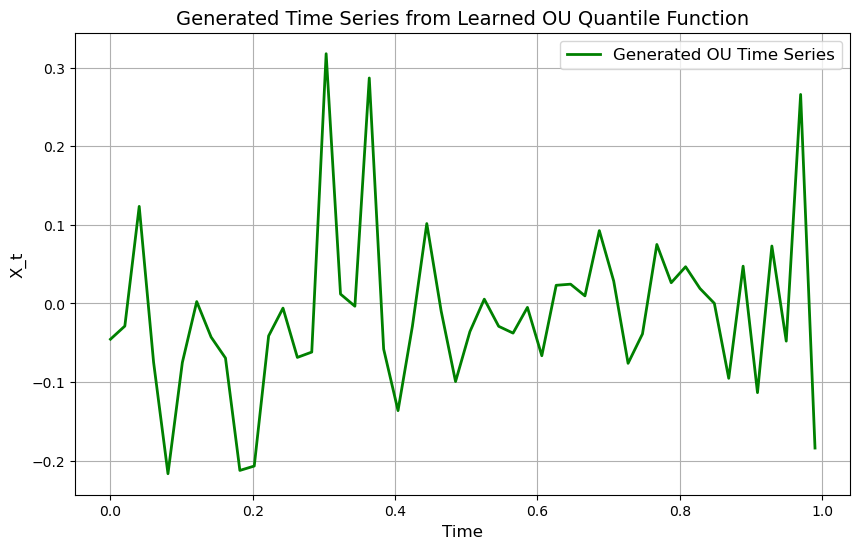

In [26]:
t_steps = np.linspace(0, 2, 100)
ou_time_series = generate_time_series(t_steps, params)

plt.figure(figsize=(10, 6))
plt.plot(t_steps, ou_time_series, label="Generated OU Time Series", color="green", linewidth=2)
plt.title("Generated Time Series from Learned OU Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

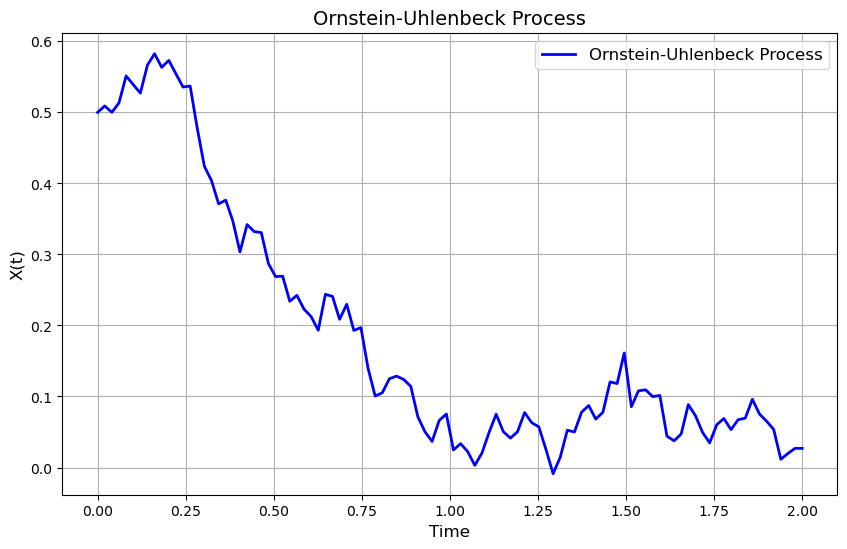

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ornstein-Uhlenbeck process
nu = 0.5       # Rate of reversion
mu = 0.0       # Long-term mean
sigma = 0.2    # Volatility
X0 = 0.5       # Initial value
T = 2.0        # Total time
n_steps = 100  # Number of time steps

# Time discretization
dt = T / n_steps
t_vals = np.linspace(0, T, n_steps)

# Generate the Ornstein-Uhlenbeck process
np.random.seed(42)  # For reproducibility
X = np.zeros(n_steps)
X[0] = X0

for i in range(1, n_steps):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener increment
    X[i] = X[i-1] + nu * (mu - X[i-1]) * dt + sigma * dW

# Plot the Ornstein-Uhlenbeck process
plt.figure(figsize=(10, 6))
plt.plot(t_vals, X, label="Ornstein-Uhlenbeck Process", color="blue", linewidth=2)
plt.title("Ornstein-Uhlenbeck Process", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X(t)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


Epoch 0: Loss = 0.042069


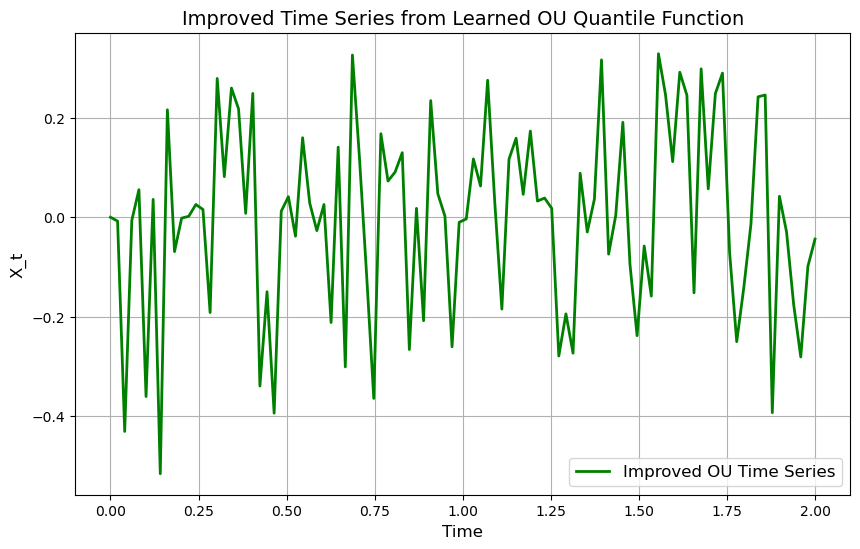

In [28]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Quantum circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# OU process parameters
nu = 0.5       # Rate of reversion
mu = 0.0       # Long-term mean
sigma = 0.2    # Volatility

# Define the quantile function for the OU process
def ou_quantile(z, t, nu=nu, mu=mu, sigma=sigma):
    """Quantile function for the OU process."""
    variance = (sigma**2 / (2 * nu)) * (1 - np.exp(-2 * nu * t))
    mean = mu
    return mean + np.sqrt(variance) * norm.ppf(z)

# Quantum circuit feature maps
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t, t_max=2.0):
    """Feature map to encode time t, normalized to fit arcsin."""
    t_normalized = t / t_max  # Normalize t to the range [0, 1]
    t_clipped = np.clip(t_normalized, 0, 1)  # Clip to avoid out-of-range values
    for i in range(n_qubits):
        qml.RY(np.arcsin(t_clipped), wires=i)


# Variational ansatz
def variational_ansatz(params):
    """Hardware-efficient ansatz with entangling CNOT gates."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(z, t, params):
    """Quantum circuit representing the quantile function."""
    feature_map_latent_variable(z)
    feature_map_time(t)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, z_vals, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, t, params) for z in z_vals])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 2  # Increased epochs for better training

# Generate finer-grained training data
t_vals = np.linspace(0.0, 2.0, 20)  # More time points
z_vals = np.linspace(0.01, 0.99, 100)  # More latent variables

# Create training dataset
training_data = []
for t in t_vals:
    targets = [ou_quantile(z, t) for z in z_vals]
    training_data.append((t, np.array(targets)))

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
for epoch in range(epochs):
    for t, targets in training_data:
        params = opt.step(lambda p: loss(p, z_vals, targets), params)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss(params, z_vals, targets):.6f}")

# Generate time-series with temporal correlation
def generate_ou_time_series(t_steps, params, initial_value=0.0):
    """Generate an OU time-series using the learned quantum circuit."""
    X = [initial_value]
    for t in t_steps[1:]:
        z_t = np.random.uniform(0, 1)  # Sample z for each time step
        X_t = quantum_circuit(z_t, t, params)  # Use the learned quantum circuit
        X.append(X_t)
    return np.array(X)

# Time steps for generation
t_steps = np.linspace(0, 2, 100)  # More time points for smoother paths
ou_time_series = generate_ou_time_series(t_steps, params)

# Plot the improved time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, ou_time_series, label="Improved OU Time Series", color="green", linewidth=2)
plt.title("Improved Time Series from Learned OU Quantile Function", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


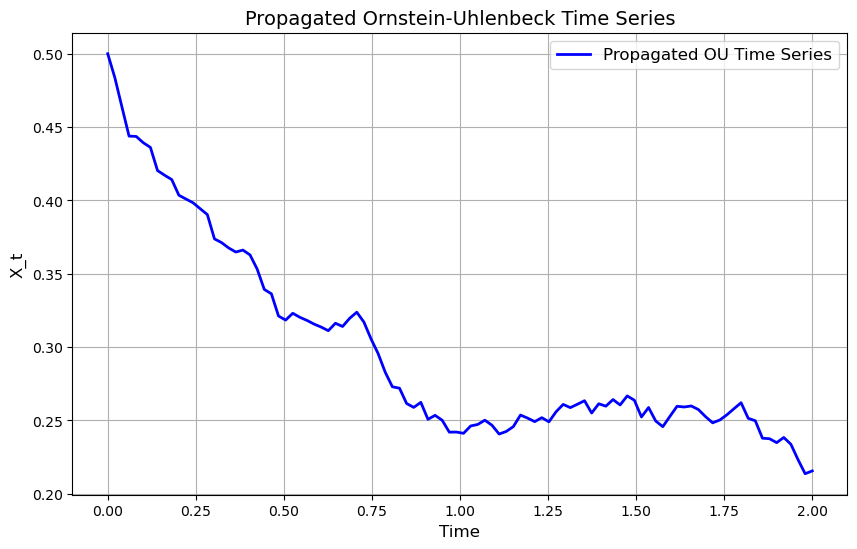

In [31]:
# Generate a time-series by propagating a single initial value
def propagate_ou_time_series(t_steps, initial_value, params, nu=nu, mu=mu, sigma=sigma):
    """Propagate a single X_t through time using the quantum model."""
    X = [initial_value]
    for i in range(1, len(t_steps)):
        t = t_steps[i]
        delta_t = t_steps[i] - t_steps[i - 1]
        
        # Sample latent variable z from U[0, 1]
        z_t = np.random.uniform(0, 1)
        
        # Use the quantum circuit to generate the next X_t
        quantile = quantum_circuit(z_t, t, params)
        noise = sigma * np.sqrt(delta_t) * quantile  # Apply learned noise scaling
        drift = nu * (mu - X[-1]) * delta_t         # Mean reversion
        
        # Update X_t
        X_next = X[-1] + drift + noise
        X.append(X_next)
    
    return np.array(X)

# Parameters for propagation
initial_X = 0.5  # Initial value of the process
t_steps = np.linspace(0, 2, 100)  # Time steps

# Generate the propagated time-series
propagated_time_series = propagate_ou_time_series(t_steps, initial_X, params)

# Plot the propagated time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, propagated_time_series, label="Propagated OU Time Series", color="blue", linewidth=2)
plt.title("Propagated Ornstein-Uhlenbeck Time Series", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
